### This is a Fork of this [Kaggle script](https://www.kaggle.com/yuansun/santander-customer-satisfaction/lb-0-84-for-starters/code).

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
train = pd.read_csv('ORG/train.csv')
print(train.shape)

(76020, 371)


In [3]:
# remove constant columns
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)
train.drop(remove, axis=1, inplace=True)

In [4]:
# remove duplicated columns
remove = []
col    = train.columns
for ii in range(len(col)-1):
    v = train[col[ii]].values
    for jj in range(ii+1, len(col)):
        if np.array_equal(v, train[col[jj]].values):
            remove.append(col[jj])
train.drop(remove, axis=1, inplace=True)

In [5]:
y = train['TARGET']
x = train.drop(['ID','TARGET'], axis=1)
print([len(y), len(x)])

[76020, 76020]


In [6]:
np.random.seed(0)
tv = np.random.choice([False, True], len(y), replace=True, p=[0.3, 0.7])

In [7]:
mt = xgb.DMatrix(x[tv].values, label=y[tv].values,
                 feature_names=x.columns.values)
mv = xgb.DMatrix(x[np.logical_not(tv)].values,
                 feature_names=x.columns.values)

In [8]:
num_round = 350
prm = {'max_depth': 5,
       'learning_rate': 0.03,
       'subsample': 0.95,
       'colsample_bytree': 0.85,
       'seed': 4242,
       'objective': 'binary:logistic',
       'silent': True}

In [9]:
prm['booster'] = 'gbtree'
xgb_gbtree = xgb.train(prm, mt, num_round)
auc_gbtree = roc_auc_score(y[np.logical_not(tv)],
                           xgb_gbtree.predict(mv))
print(auc_gbtree)

0.840068231475


In [10]:
prm['booster']        = 'dart'
prm['sample_type']    = 'uniform'
prm['normalize_type'] = 'forest'
prm['rate_drop']      = 0.1
rate     = [0.1, 0.3, 0.5, 0.7, 0.9]
auc_dart = []
for p in rate:
    prm['skip_drop'] = p
    xgb_dart = xgb.train(prm, mt, num_round)
    auc_dart.append(roc_auc_score(y[np.logical_not(tv)],
                                  xgb_dart.predict(mv, num_round)))

In [11]:
df = pd.DataFrame(index=rate)
df['gbtree'] = auc_gbtree
df['dart']   = auc_dart

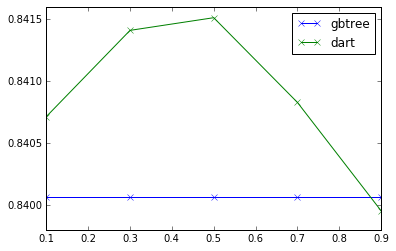

In [12]:
df.plot(style='x-')

The leaf scores of dropped trees $F_i$ and new trees $\tilde{F}$
$$ \displaystyle
D = \sum_{i=1}^k F_i \sim \tilde{F}
$$

normalize_type: tree
$$\displaystyle
\alpha \left( \sum_{i=1}^k F_i + \frac{1}{k} F \right) =
\alpha \left( \sum_{i=1}^k F_i + \frac{\lambda}{k} \tilde{F} \right) \sim \alpha \left( 1 + \frac{\lambda}{k} \right) D = D, \quad
\alpha = \frac{k}{k + \lambda}
$$

normalize_type: forest
$$ \displaystyle
\alpha \left( \sum_{i=1}^k F_i + F \right)
= \alpha \left( \sum_{i=1}^k F_i + \lambda \tilde{F} \right)
\sim \alpha \left( 1 +\lambda \right) D = D, \quad
\alpha = \frac{1}{1 + \lambda}
$$